In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Layer, Embedding, GRU, Bidirectional, LSTM, GlobalAveragePooling2D , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.utils import  Sequence 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import HeNormal
from tqdm.notebook import tqdm
import cv2 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


2024-07-22 11:20:15.490922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 11:20:15.491012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 11:20:15.633528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Tokenizer 

In [2]:
with open("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/all_qa_pairs.txt" , 'r') as file:
    text = file.read()
text = text.split('\n')
tokenizer = Tokenizer(filters = '' , oov_token= '<OOV>')
tokenizer.fit_on_texts(text)

In [3]:
sample_questions = 'what is the color of the chair ?'
sequece_tokens = tokenizer.texts_to_sequences([sample_questions])
print(sequece_tokens)

[[5, 6, 2, 61, 7, 2, 23, 4]]


In [4]:
sequence_to_text = tokenizer.sequences_to_texts(sequece_tokens)
print(sequence_to_text)

['what is the color of the chair ?']


In [5]:
answer = 'chair'
seq_ans = tokenizer.texts_to_sequences([answer])
print(seq_ans)

[[23]]


In [6]:
sqe_to_ans = tokenizer.sequences_to_texts(seq_ans)
print(sqe_to_ans)

['chair']


In [7]:
start_token = '<start>'
end_token = '<end>'
anser_token = "answer"
question_token  = 'question'
tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
tokenizer.word_index[end_token] = len(tokenizer.word_index) + 2
tokenizer.word_index[anser_token] = len(tokenizer.word_index) + 3
tokenizer.word_index[question_token] = len(tokenizer.word_index) + 4
tokenizer.index_word[tokenizer.word_index[start_token]] = start_token
tokenizer.index_word[tokenizer.word_index[end_token]] = end_token
tokenizer.index_word[tokenizer.word_index[anser_token]] = anser_token
tokenizer.index_word[tokenizer.word_index[question_token]] = question_token

In [8]:
answer_start_token  = f"{start_token}  chair {end_token}"
seq_ans = tokenizer.texts_to_sequences([answer_start_token])
print(seq_ans)


[[3132, 23, 3134]]


In [9]:
tokenizer.word_index[end_token] ,  tokenizer.word_index[start_token] 

(3134, 3132)

In [10]:
tokenizer.texts_to_sequences(["<start>  answer of this  question is  chair <end>"])

[[3132, 3136, 7, 119, 3138, 6, 23, 3134]]

In [11]:
tokenizer.sequences_to_texts(seq_ans)

['<start> chair <end>']

In [12]:
vocab_size = len(tokenizer.word_index) + 1  

In [13]:
vocab_size

3136

In [14]:
# Anwser classes 
anwser_txt =  '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/answer_space.txt'
with open(anwser_txt , 'r') as file:
    classes = file.read().splitlines()
num_classes = len(classes)
classes_to_idx = {class_name:idx for idx , class_name in enumerate(classes)}
idx_to_classes = {idx:class_name for idx , class_name in enumerate(classes)}

In [15]:
classes_to_idx['chair'] , idx_to_classes[106]

(106, 'chair')

# DataGenerator 

In [16]:
class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, tokenizer,class_to_index,  batch_size=32, max_len=20, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.shuffle = shuffle
        self.class_to_idx = class_to_index
        self.max_len = max_len
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start_index:end_index]
        
        batch_images, batch_questions, batch_answers = [], [], []
        
        for idx in batch_indexes:
            row = self.dataframe.iloc[idx]
            image_id = row['image_id']
            image_path = f"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/{image_id}.png"
            question = row['question']
            answer = row['answer']
            
            image_data, question, answer_idx = self.preprocess(image_path, question, answer)
            
            batch_images.append(image_data)
            batch_questions.append(question)
            batch_answers.append(answer_idx)
        
        batch_images = np.array(batch_images, dtype=np.float32)
        batch_questions = np.array(batch_questions, dtype=np.int32)
        batch_answers = np.array(batch_answers, dtype=np.int32)
        
        inputs = (tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_questions, dtype=tf.int32))
        targets = tf.convert_to_tensor(batch_answers, dtype=tf.int32)
        
        return inputs, targets

    def preprocess(self, image_path, question, answer):
        image_data = cv2.imread(image_path)
        new_shape = (224, 224)
        image_data = cv2.resize(image_data, new_shape)
        image_data = image_data / np.max(image_data) 
        
        question = self.tokenize(question, self.max_len)
        
        answer_choices = answer.split(', ')
        answers = []
        for ans in answer_choices:
            answers.append(ans) 
            answer = answers[0]
            answer = self.class_to_idx[answer]
        return image_data, question, answer

    def tokenize(self, text, max_seq_len):
        tokens = self.tokenizer.texts_to_sequences([text])[0]
        tokens = tokens[:max_seq_len]
        tokens = pad_sequences([tokens], maxlen=max_seq_len, padding='post')[0]
        return tokens

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [17]:
train_df = pd.read_csv("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv")
val_df  = pd.read_csv("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv")

In [18]:
train_data = CustomDataGenerator(train_df ,tokenizer = tokenizer , class_to_index= classes_to_idx)

In [19]:
for inputs , targets in train_data:
    print(inputs[0].shape)
    print(inputs[1].shape)
    print(targets.shape)
    break

(32, 224, 224, 3)
(32, 20)
(32,)


In [20]:

def detokenize_sequence( tokenizer,sequence):
    word_index = tokenizer.word_index
    index_to_word = {idx: word for word, idx in word_index.items()}
    
    if isinstance(sequence, tf.Tensor):
        sequence = sequence.numpy()
    
    # Ensure sequence is 1-dimensional
    sequence = sequence.flatten()

    text = " ".join([index_to_word.get(int(token), '') for token in sequence if int(token) != 0])
    return text

In [21]:
for inputs , answers in train_data:
    image  , questions = inputs 
    
    print("Decoded questions")
    question = [detokenize_sequence(tokenizer , q) for q in questions ]
    print(question)
    print("\n")
    print("Decoded answers")
    if isinstance(answers, tf.Tensor):
        answers = answers.numpy()
    
    # Ensure sequence is 1-dimensional
    answers = answers.flatten()
    answers = [idx_to_classes[ans] for ans in answers]
    print(answers)
    break


Decoded questions
['what is the round object in front of the blue boxes at the end of the room', 'what is the object in front of the table', 'what is on the right side of the drawer', 'what is the colour of the bed sheet', 'what is at the bottom left', 'what is the object close to the wall above the bathtub', 'what object is fitted in the cabinet', 'what is in front of the bed', 'what is beneath the bag', 'what is on the left side of the bottle of liquid', 'what is in front of the monitor', 'what is on the drawer', 'how many drawer knobs are there', 'what is the colour of the wall', 'what is beneath the blinds', 'what are the chairs surrounding', 'what are stuck on the wall', 'what is the object on the floor right side of the table', 'what is the colour of door', 'what is above the bed', 'what is to the right of table', 'what is the number on the frame', 'how many plum pillows are there on the brown carpet and next to the bed', 'how many pillows are there on the bed', 'what is right to

# Model 

In [23]:
# Image Encoder
class ImageEncoder(tf.keras.Model):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        self.model = tf.keras.Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.5), 
            Dense(1024, activation='relu')
        ])

    def call(self, x):
        return self.model(x)

# Language Encoder
class LanguageEncoder(tf.keras.Model):
    def __init__(self, vocab_size, emb_dims):
        super(LanguageEncoder, self).__init__()
        self.emb = Embedding(vocab_size, emb_dims)
        self.rnn = Bidirectional(LSTM(emb_dims, return_sequences=False))

    def call(self, text):
        emb = self.emb(text)
        output = self.rnn(emb)
        return output

# Vision-Language Model
class VisionLanguageModel(tf.keras.Model):
    def __init__(self, vocab_size, emb_dims, num_classes):
        super(VisionLanguageModel, self).__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = LanguageEncoder(vocab_size, emb_dims)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense = Dense(num_classes, activation='softmax')

    def call(self, data, training=False):
        image, questions = data

        image_feature = self.image_encoder(image)

        question_feature = self.text_encoder(questions)

        concat = tf.concat([image_feature, question_feature], axis=-1)
        
        output = self.dropout(concat, training=training)
        output = self.dense(output)
        
        return output

In [24]:
# Training # Example usage
vocab_size = vocab_size
emb_dims = 512
num_classes = len(classes_to_idx)
model = VisionLanguageModel(vocab_size, emb_dims,num_classes)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.compile(loss= 'SparseCategoricalCrossentropy' , metrics = ['accuracy'] , optimizer = 'adam')
model.summary()

Model: "vision_language_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_encoder (ImageEncoder)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ language_encoder                │ ?                      │   0 (unbuilt) │
│ (LanguageEncoder)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
train_data = CustomDataGenerator(train_df , tokenizer , classes_to_idx)
val_data = CustomDataGenerator(val_df , tokenizer , classes_to_idx)

In [32]:
history  = model.fit(train_data , validation_data = val_data , epochs = 4)

Epoch 1/4
311/311 ━━━━━━━━━━━━━━━━━━━━ 152s 478ms/step - accuracy: 0.4596 - loss: 1.9957 - val_accuracy: 0.2541 - val_loss: 3.8631
Epoch 2/4
311/311 ━━━━━━━━━━━━━━━━━━━━ 152s 478ms/step - accuracy: 0.4900 - loss: 1.8741 - val_accuracy: 0.2492 - val_loss: 3.8355
Epoch 3/4
311/311 ━━━━━━━━━━━━━━━━━━━━ 166s 526ms/step - accuracy: 0.5219 - loss: 1.7682 - val_accuracy: 0.2537 - val_loss: 3.9474
Epoch 4/4
311/311 ━━━━━━━━━━━━━━━━━━━━ 153s 483ms/step - accuracy: 0.5323 - loss: 1.6892 - val_accuracy: 0.2512 - val_loss: 3.9713


In [33]:
model.save("VQMMODEL.h5")

# Plot training metrics 

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)


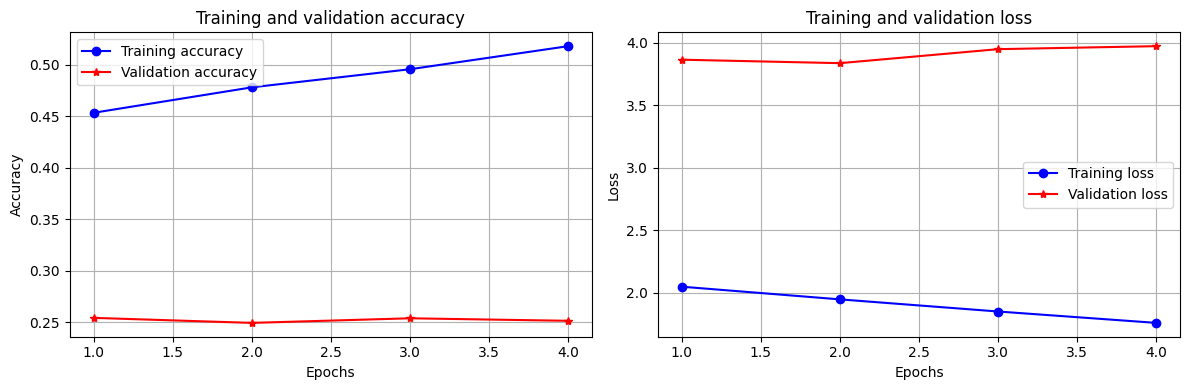

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy with customizations
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', linestyle='-', color='blue', label='Training accuracy')
plt.plot(epochs, val_accuracy, marker='*', linestyle='-', color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot loss with customizations
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', linestyle='-', color='blue', label='Training loss')
plt.plot(epochs, val_loss, marker='*', linestyle='-', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Prediction 

In [38]:
def tokenize(tokenizer ,text ,  max_seq_len = 20):
        tokens = tokenizer.texts_to_sequences([text])[0]
        tokens = tokens[:max_seq_len]
        tokens = pad_sequences([tokens], maxlen=max_seq_len, padding='post')[0]
        return tokens

def prediction(image_path, question):
    # Read and preprocess the image
    image_data = cv2.imread(image_path)
    image_data = cv2.resize(image_data, (224, 224))
    image_data = image_data / np.max(image_data)  
    image_data = np.expand_dims(image_data, axis=0)  
    question_tokens = tokenize(tokenizer , question)
    question_tokens = tf.expand_dims(question_tokens, axis=0)  
    prediction = model.predict([image_data, question_tokens])
    predicted_class_index = np.argmax(prediction, axis=-1)[0]  
    label = idx_to_classes[predicted_class_index] 
    
    return label


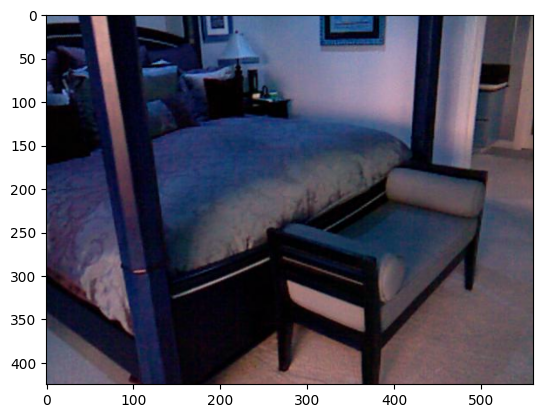

In [46]:
plt.imshow(cv2.imread("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image942.png"))
plt.show()

In [45]:
question = "how many picture are on the wall"
answer = prediction("/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image942.png",question )
print(answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2
